<a href="https://colab.research.google.com/github/RipeMangoBox/STARRY/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 - Configuration Setup

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from torchvision import datasets, transforms
from typing import List, Callable, Union, Any, TypeVar, Tuple
from sklearn.manifold import TSNE
import pandas as pd




# Step 2 - VAE Model

## Resnet_Encoder

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, input_channels = 3, latent_dim = 64):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.classfier = nn.Linear(512*block.expansion, num_classes)
        self.input_channels = input_channels
        self.latent_dim = latent_dim

        self.mu = nn.Linear(512*block.expansion, self.latent_dim)
        self.log_var = nn.Linear(512*block.expansion, self.latent_dim)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        mu = self.mu(out)
        log_var = self.log_var(out)
        # out = self.classfier(out)
        
        return mu, log_var


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet101()
    mu, log_var = net(torch.randn(2, 3, 32, 32))
    print(mu.shape, log_var.shape)

test()

torch.Size([2, 64]) torch.Size([2, 64])


## Linear_Encoder

In [66]:
class Linear_Encoder(nn.Module):
    def __init__(self,
                 image_size: int,
                 layer_sizes: List,
                 latent_dim: int,
                 input_channels: int = 1):
        super().__init__()
        
        self.input_channels = input_channels
        self.layer_sizes = layer_sizes.copy()
        self.image_size = image_size
        self.MLP = nn.Sequential()

        for i, (in_size, out_size) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())

        self.mu = nn.Linear(self.layer_sizes[-1], latent_dim)
        self.log_var = nn.Linear(self.layer_sizes[-1], latent_dim)


    def forward(self, x):
        x = x.view(-1, self.input_channels * self.image_size * self.image_size)
        x = self.MLP(x)
        mu = self.mu(x)
        log_vars = self.log_var(x)

        return mu, log_vars
    
def test():
    x = torch.randn(6, 3, 32, 32)
    encoder = Linear_Encoder(32, [32*32, 512, 256, 128], 64, 3)
    mu, log_var = encoder(x)
    print(mu.shape, log_var.shape)

test()

torch.Size([6, 64]) torch.Size([6, 64])


In [67]:
class Encoder(nn.Module):
    def __init__(self,
                 image_size: int,
                 layer_sizes: List,
                 latent_dim: int,
                 input_channels: int = 1,
                 use_linear: bool = False):
        super().__init__()

        if use_linear == True:
            self.MLP = Linear_Encoder(image_size, layer_sizes, latent_dim, input_channels)
        else:
            self.MLP = ResNet18()

    def forward(self, x):
        mu, log_vars = self.MLP(x)
        return mu, log_vars

class Decoder(nn.Module):
    def __init__(self,
                 layer_sizes: List,
                 latent_dim: int,
                 output_channels: int = 1):
        super().__init__()

        self.MLP = nn.Sequential()
        self.output_channels = output_channels

        input_size = latent_dim

        for i, (in_size, out_size) in enumerate(zip([input_size] + layer_sizes[:-1], layer_sizes)):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            if i+1 < len(layer_sizes):
                self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())
            else:
                self.MLP.add_module(name="sigmoid", module=nn.Sigmoid())

    def forward(self, z):
        x = self.MLP(z)

        return x
    
def test():
    z = torch.randn(6, 64)
    decoder = Decoder([32*32, 512, 256, 128], 64, 3)
    recon = decoder(z)
    print(recon.shape)

test()

torch.Size([6, 384])


In [68]:
class VAE(nn.Module):
  def __init__(self, 
               config: dict = None,
               use_linear: bool = False):
    super(VAE, self).__init__()

    self.image_size = config.image_size
    self.input_dim = config.input_channel
    self.layer_sizes = config.layer_sizes
    self.fc_dim = config.fc_dim
    self.latent_dim = config.latent_dim

    self.beta = 1

    self.encoder = Encoder(self.image_size, self.layer_sizes, self.latent_dim, self.input_dim, use_linear=use_linear)
    self.decoder = Decoder(self.layer_sizes[::-1], self.latent_dim, self.input_dim)

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x):
    mu, log_var = self.encoder(x)
    
    z = self.reparameterize(mu, log_var)
    # print(f'mu: {mu.shape}, log_var: {log_var.shape}')
    recon = self.decoder(z)
    return self.decoder(z), mu, log_var

  def calc_loss(self, x, recon_x, mu, log_var):
    # print(f'recon_x: {recon_x.shape}, x: {x.shape}')
    recons_loss = F.mse_loss(recon_x, x.view(-1, self.input_dim*self.image_size*self.image_size), reduction="sum").div(x.shape[0])
    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu** 2 - log_var.exp(), dim = 1), dim = 0)
    return recons_loss + self.beta * kld_loss

# Step 3 - Training

In [69]:
def idx2onehot(idx, n):

    assert torch.max(idx).item() < n

    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    
    return onehot

In [70]:
class Config:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)


In [71]:
MNIST_config = Config(
    image_size = 28,
    layer_sizes = [1*28*28, 256],
    fc_dim = 128,
    latent_dim = 64,
    batch_size = 128,
    epochs = 10,
    input_channel = 1,
)

CIFAR10_config = Config(
    image_size = 32,
    layer_sizes = [3*32*32, 512, 256, 128],
    fc_dim = 128,
    latent_dim = 64,
    batch_size = 128,
    epochs = 50,
    input_channel = 3,
)


transform=transforms.Compose([
    transforms.ToTensor()
])


In [72]:
DATASET_Opt = 'CIFAR10'

if DATASET_Opt == 'MNIST':
    args = MNIST_config
    dataset1 = datasets.MNIST('../data/', train=True, download=True,
                    transform=transform)
    dataset2 = datasets.MNIST('../data/', train=False,
                    transform=transform)
else:
    args = CIFAR10_config
    dataset1 = datasets.CIFAR10('../data/', train=True, download=True,
                    transform=transform)
    dataset2 = datasets.CIFAR10('../data/', train=False,
                    transform=transform)

# 超参
image_size, layer_sizes, fc_dim, latent_dim, batch_size, epochs, input_channel = vars(args).values()

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified


In [73]:
model = VAE(args, use_linear=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [74]:
print_freq = 200
for epoch in range(epochs):
    print("Start training epoch {}".format(epoch,))
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        recon, mu, log_var = model(images)
        loss = model.calc_loss(images, recon, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
            print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item()))

Start training epoch 0
	 [199/391]: loss 113.8025894165039
	 [390/391]: loss 108.55672454833984
Start training epoch 1
	 [199/391]: loss 113.11468505859375
	 [390/391]: loss 98.44287109375
Start training epoch 2
	 [199/391]: loss 99.03075408935547
	 [390/391]: loss 93.27685546875
Start training epoch 3
	 [199/391]: loss 90.04850769042969
	 [390/391]: loss 98.4367904663086
Start training epoch 4
	 [199/391]: loss 89.06205749511719
	 [390/391]: loss 94.13668823242188
Start training epoch 5
	 [199/391]: loss 95.42290496826172
	 [390/391]: loss 90.37301635742188
Start training epoch 6
	 [199/391]: loss 95.76473999023438
	 [390/391]: loss 91.28260803222656
Start training epoch 7
	 [199/391]: loss 92.77117919921875
	 [390/391]: loss 91.6779556274414
Start training epoch 8
	 [199/391]: loss 79.89775848388672
	 [390/391]: loss 88.98816680908203
Start training epoch 9
	 [199/391]: loss 87.11686706542969
	 [390/391]: loss 89.09603118896484
Start training epoch 10
	 [199/391]: loss 80.96046447753

KeyboardInterrupt: 

# Step 4 - Results

torch.Size([64, 3072])


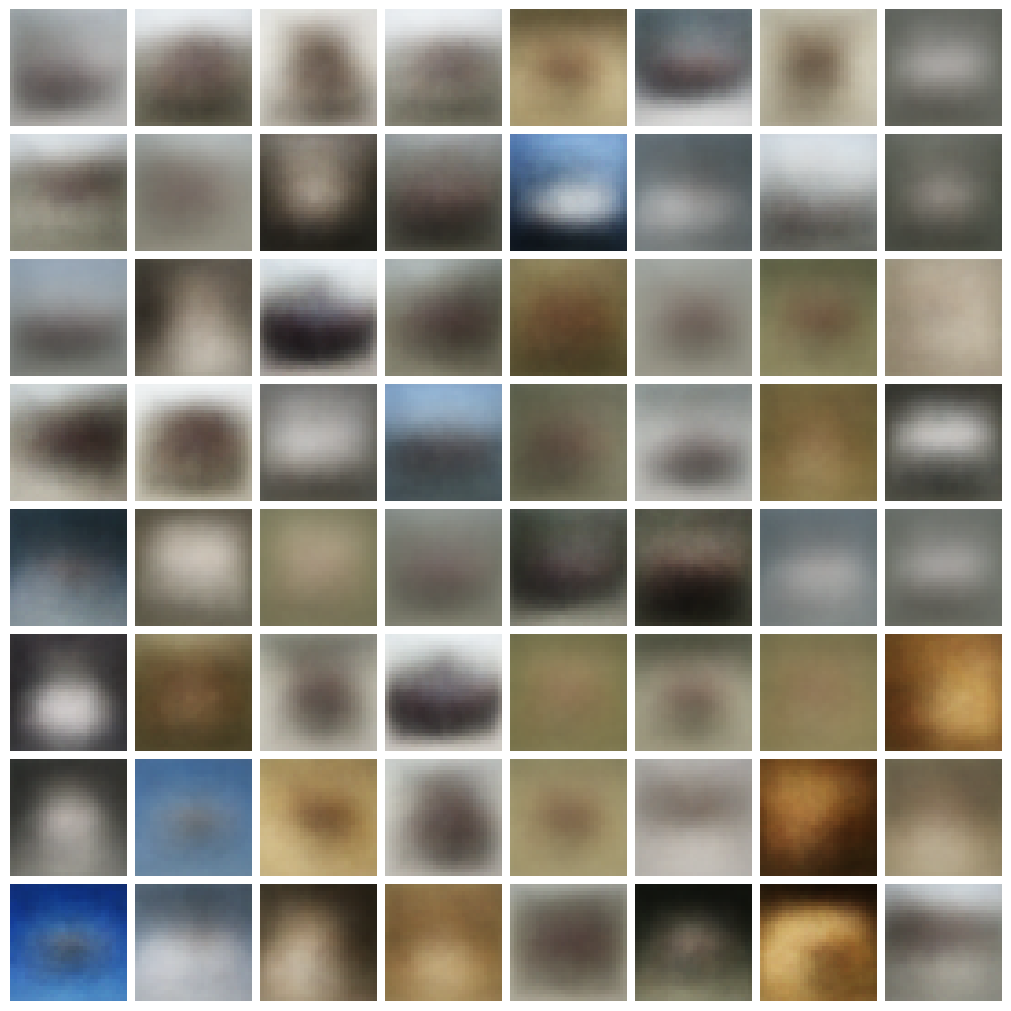

In [ ]:
## generate new images by VAE

n_rows = 8
n_cols = 8

sample_zs = torch.randn(n_rows * n_cols, latent_dim).to(device)

model.eval()

with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    print(generated_imgs.shape)
    
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, input_channel, image_size, image_size)

fig = plt.figure(figsize=(10,  10), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)

for n_row in range(n_rows):
    for n_col in range(n_cols):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = generated_imgs[n_row, n_col]  # 获取图像数据
        if DATASET_Opt == 'MNIST':
            f_ax.imshow(img.squeeze(), cmap='gray')  # 对于 MNIST，去除单通道维度
        else:  # 对于 CIFAR10 或其他 RGB 图像，保留通道维度放到最后
            f_ax.imshow(img.transpose(1, 2, 0))
        f_ax.axis("off")

plt.show()

# Step 5 - Visualization

In [ ]:
def plot_latent_space_tsne(variable='mu', nums=1000):
  model.eval()
  with torch.no_grad():
    latent_vectors = []
    labels = []
    for data, label in test_loader:
      data = data.to(device)
      recon_x, mu, logvar = model(data)

      z = model.reparameterize(mu, logvar) if variable == 'z' else mu
      latent_vectors.append(z.cpu())
      labels.append(label)
    latent_vectors = torch.cat(latent_vectors, dim=0)[:nums]
    labels = torch.cat(labels, dim=0)[:nums]

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=2023)
    latent_tsne = tsne.fit_transform(latent_vectors)

    # Plot t-SNE
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f't-SNE Visualization of Latent Space {variable}')
    plt.show()

### $\mu$的可视化

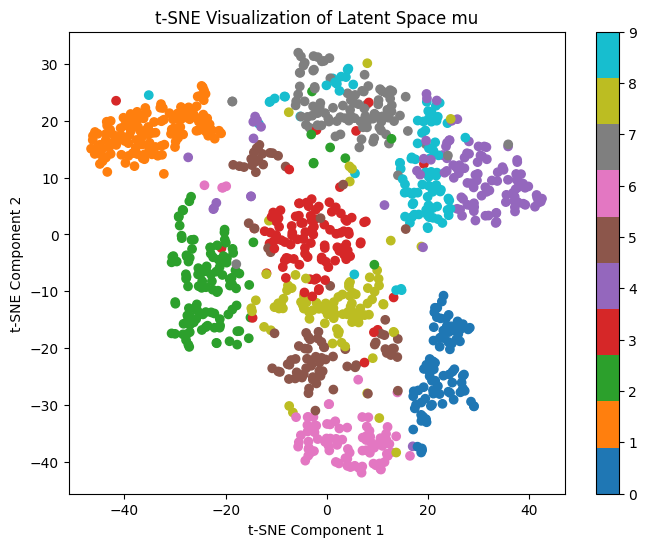

In [ ]:
plot_latent_space_tsne('mu', 1000)

### z的可视化

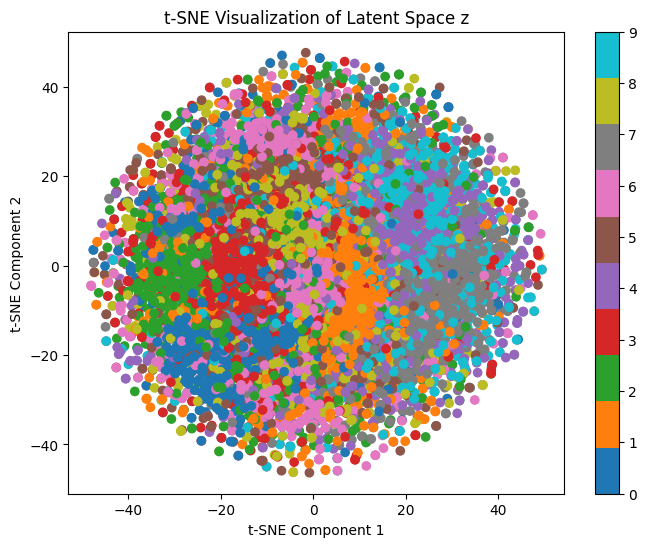

In [ ]:
# 由于方差存在，z的可视化需要远比mu多的点才能看出效果
plot_latent_space_tsne('z', None)